In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

In [2]:
def add_label_to_df(df, path_to_labels):
    if Path(path_to_labels).is_dir():
        series_to_labels_mapping = {}
        for path in Path(path_to_labels).glob('*.json'):
            with open(path, 'r') as file:
                labels = json.load(file)
                series_to_labels_mapping.update({
                    f"{path.stem}": labels
                })
    elif Path(path_to_labels).is_file():
        with open(path_to_labels, 'r') as file:
            series_to_labels_mapping = json.load(file)
    else:
        raise ValueError(f"path_to_labels ''{path_to_labels}' must be file or directory'")
    labels_mapping_list = [
        {
            "series_uuid": series,
            "foreground_label": int(value),
            "label_description": ','.join([value_.lower().strip() for value_ in label.split(',')])
        }
        for series, mapping in series_to_labels_mapping.items()
        for value, label in mapping.items()
    ]
    labels_mapping_df = pd.DataFrame(labels_mapping_list)
    new_df = df.copy()
    new_df["series_uuid"] = new_df["ct_fname"].apply(lambda x: x.split('.nii.gz')[0])
    merged_df = new_df.merge(labels_mapping_df, on=["series_uuid", "foreground_label"], how='left')
    return merged_df

In [3]:
path_to_performance = Path.cwd() / "resources" / "performance_iteration_0.json"
path_to_labels = Path.cwd() / "resources" / "labels"
with open(path_to_performance, 'r') as file:
    performance = json.load(file)
performance_df = pd.DataFrame(performance['bboxes'])
performance_df = add_label_to_df(performance_df, path_to_labels)

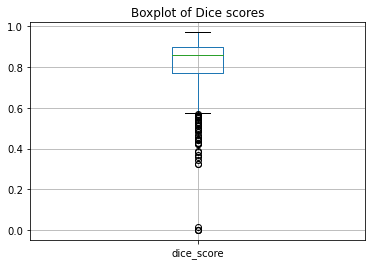

,dice_score,annotated_pixels,predicted_pixels
count,585.000000,585.000000,585.000000
mean,0.810139,169.177778,178.786325
std,0.140890,110.763118,131.571145
min,0.000000,2.000000,0.000000
25%,0.769912,93.000000,83.000000
50%,0.857831,149.000000,150.000000
75%,0.900302,210.000000,230.000000
max,0.970982,562.000000,616.000000


In [4]:
performance_df.boxplot(column='dice_score')
plt.title(f"Boxplot of Dice scores")
plt.show()
performance_df[[
    'dice_score',
    'annotated_pixels',
    'predicted_pixels'
]].describe()

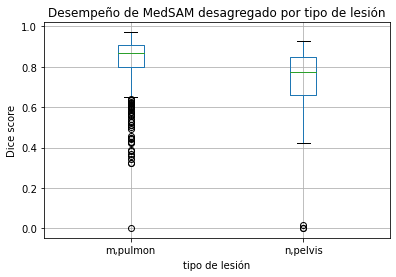

dice_score                                               \
                       count      mean       std  min       25%       50%   
label_description                                                           
m,pulmon               476.0  0.828493  0.125744  0.0  0.800000  0.867825   
n,pelvis               109.0  0.729988  0.172705  0.0  0.661355  0.775385   

                                      annotated_pixels              ...  \
                        75%       max            count        mean  ...   
label_description                                                   ...   
m,pulmon           0.906073  0.970982            476.0  171.878151  ...   
n,pelvis           0.850202  0.927711            109.0  157.385321  ...   

                                predicted_pixels                               \
                     75%    max            count        mean         std  min   
label_description                                                               
m,pulmon           217.5  562.0            476.0  187.527311  140.865420  0.0   
n,pelvis           188.0  392.0            109.0  140.614679   67.285862  0.0   

                                               
                     25%    50%    75%    max  
label_description                              
m,pulmon           77.75  157.5  248.0  616.0  
n,pelvis           94.00  132.0  173.0  334.0  

[2 rows x 24 columns]

In [5]:
performance_df.boxplot(column='dice_score', by='label_description')
plt.xlabel('tipo de lesión')
plt.ylabel('Dice score')
plt.suptitle('')
plt.title('Desempeño de MedSAM desagregado por tipo de lesión')
#plt.savefig(
#    Path.cwd() / "resources" / "boxplot_performance_by_lesion_type.png",
#    transparent=True,
#    bbox_inches='tight'
#)
plt.show()
display(performance_df.groupby('label_description')[[
    'dice_score',
    'annotated_pixels',
    'predicted_pixels'
]].describe())

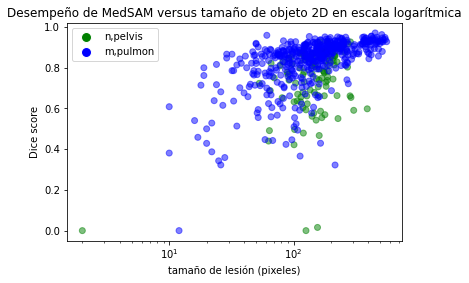

In [6]:
_, ax = plt.subplots()
# Add a color for each unique label description
color_mapping = {
    "m,pulmon": 'blue',
    "n,pelvis": 'green'
}
colors = performance_df["label_description"].map(color_mapping)
ax.scatter(
    performance_df['annotated_pixels'],
    performance_df['dice_score'],
    c=colors.to_list(),
    label=performance_df["label_description"],
    alpha=0.5
)
ax.set_xscale('log')
ax.set_title('Desempeño de MedSAM versus tamaño de objeto 2D en escala logarítmica')
ax.set_xlabel('tamaño de lesión (pixeles)')
ax.set_ylabel('Dice score')
# Create legend labels based on unique values in 'label_description' column
legend_labels = [
    Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_mapping[value], label=value)
    for value in performance_df['label_description'].unique()
]
ax.legend(handles=legend_labels)
#plt.savefig(
#    Path.cwd() / "resources" / "scatterplot_performance_vs_object_size.png",
#    transparent=True,
#    bbox_inches='tight'
#)
plt.show()